# Scania Test Failures Project

#### This project was focused on performing predictive maintenance on Trucks and finding a model that results in the lowest maintenance - it is 10 dollars/truck to run a test, and 500 dollars/truck for each failure we must repair. 
#### This notebook creates multiple models to discover which one works best and results in the lowest overall cost to the Scania Truck company 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier

### Importing the data 

In [2]:
train_data = pd.read_csv("Training_Data_NaN.csv", na_values='na')
train_med = pd.read_csv("Training_Data_Median.csv")
test_data = pd.read_csv("Test_Data_NaN.csv", na_values='na')
test_med = pd.read_csv("Test_Data_Median.csv")

#### Performing basic feature engineering 

In [3]:
train_data = train_data.drop(columns = ['Unnamed: 0'], axis = 1)
train_med = train_med.drop(columns = ['Unnamed: 0'], axis = 1)
test_data = test_data.drop(columns = ['Unnamed: 0'], axis = 1)
test_med = test_med.drop(columns = ['Unnamed: 0'], axis = 1)

In [4]:
y_train = train_data['class']
train_data.drop(['class'],axis = 1,inplace = True)
train_med.drop(['class'],axis = 1,inplace = True)

In [5]:
y_test = test_data['class']
test_data.drop(['class'],axis = 1,inplace = True)
test_med.drop(['class'],axis = 1,inplace = True)

## Creating the model: Random Forest with Bootstrapping 

In [7]:
#Have to do this one using the Data Set with the median values, can't take NaN

SEED = 4
num_trees = 90

#Separating our data for validation 
X_train, X_val, Y_train, Y_val = train_test_split(train_med, y_train, test_size = 0.2, stratify = y_train, random_state = SEED)

#Model from sci-kit learn 
model_full_rf = RandomForestClassifier(n_estimators = num_trees, class_weight = 'balanced', 
                                       random_state = SEED, n_jobs = -1, max_features = 'log2')

#Training the model 
model_full_rf.fit(X_train, Y_train)

#Calculating the model metrics/scores from validation data 
model_full_rf.score(X_val, Y_val) 

0.99325

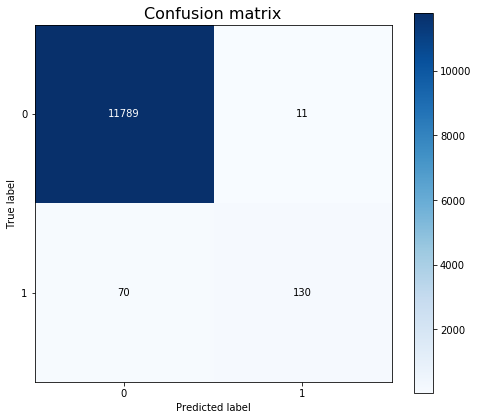

35110

In [8]:
#Predicting using model on the test data 
y_pred = model_full_rf.predict(X_val)
y_pred_proba = model_full_rf.predict_proba(X_val)

#Calculating the confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_val, y_pred).ravel()

#Visualizing the confusion matrix
skplt.metrics.plot_confusion_matrix(Y_val, y_pred, normalize = False, figsize=(8, 7))
plt.title("Confusion matrix", fontsize = 16)
plt.ylim(1.5, -0.5)
plt.show()

#Calculate the cost when we use this model
10*fp + 500*fn 

In [9]:
scores = model_full_rf.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(Y_val, scores)

In [10]:
min_cost = np.inf
best_thresh = 0.2
costs = []

for thresh in thresholds:
    y_pred_thresh = scores > thresh
    tn, fp, fn, tp = confusion_matrix(Y_val, y_pred_thresh).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    
    if cost < min_cost:
        min_cost = cost
        best_thresh = thresh
        
print("These values are on the Validation Set")
print("Best threshold: {:.4f}".format(best_thresh))
print("Min cost: {:.2f}".format(min_cost))

These values are on the Validation Set
Best threshold: 0.0444
Min cost: 6970.00


In [45]:
y_pred_test_final = model_full_rf.predict_proba(test_med)[:,1] > best_thresh
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_final).ravel()

10*fp + 500*fn

11660

In [46]:
recall = tp / (tp + fn)
recall

0.96

In [13]:
# Defining the Logistic Regression model and performing the hyper parameter tuning using gridsearch
params = {'C' : [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3], 'penalty': ['l1', 'l2']}
clf = LogisticRegression(n_jobs = -1,random_state = 42)
clf.fit(train_med, y_train)

/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [16]:
model = GridSearchCV(estimator = clf,cv = 2,n_jobs = -1,param_grid = params,scoring = 'f1',verbose = 2)

In [17]:
model.fit(train_med, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 60.5min finished
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [18]:
print("Best estimator is", model.best_params_)

Best estimator is {'C': 0.0001, 'penalty': 'l1'}


In [ ]:
#Best estimator is {'C': 0.0001, 'penalty': 'l1'}

In [30]:
# model fitting using the best parameter.
clf = LogisticRegression(n_jobs = -1, C = 5000,penalty = 'l1')
clf.fit(train_med,y_train)
y_pred = clf.predict(test_med)
con_mat = confusion_matrix(y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15573    52]
 [  109   266]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  52
Type 2 error (False Negative) =  109
---------------------------------------------------------------------------------------------------------------------
Total cost =  55020
---------------------------------------------------------------------------------------------------------------------


/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [34]:
min_cost

6970

In [43]:
# model fitting and hyper parameter tuning to find the best parameter.
x_cfl = XGBClassifier()
prams = {'n_estimators':[100,200,500,1000,2000], 'max_depth':[3,5,10]}
model = GridSearchCV(x_cfl, param_grid = prams,verbose = 10,n_jobs = -1, scoring = 'f1', cv = 5)
model.fit(train_med, y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 102.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 136.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 194.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 236.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 343.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 500}


In [ ]:
# Best estimator is {'max_depth': 10, 'n_estimators': 500}

In [44]:
#model fitting with the best parameter.
clf = XGBClassifier(max_depth = 10, n_estimators = 500, n_jobs = -1)
clf.fit(train_med, y_train)
y_pred = clf.predict(test_med)
con_mat = confusion_matrix(y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15611    14]
 [   79   296]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  14
Type 2 error (False Negative) =  79
---------------------------------------------------------------------------------------------------------------------
Total cost =  39640
---------------------------------------------------------------------------------------------------------------------


In [50]:
train_data[0:20]

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
5,38312,NaN,2.130706e+09,218.0,0.0,0.0,0.0,0.0,0.0,0.0,...,388574.0,288278.0,900430.0,300412.0,1534.0,338.0,856.0,0.0,0.0,0.0
6,14,0.0,6.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,168.0,48.0,60.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
7,102960,NaN,2.130706e+09,116.0,0.0,0.0,0.0,0.0,0.0,0.0,...,715518.0,384948.0,915978.0,1052166.0,1108672.0,341532.0,129504.0,7832.0,0.0,0.0
8,78696,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,699290.0,362510.0,1190028.0,1012704.0,160090.0,63216.0,41202.0,4.0,0.0,0.0
9,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0


In [49]:
test_data[0:20]

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
5,174,NaN,2.600000e+01,24.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
6,40202,NaN,6.400000e+02,606.0,0.0,0.0,0.0,0.0,0.0,0.0,...,526218.0,239734.0,439556.0,374248.0,169096.0,53658.0,41054.0,320.0,0.0,0.0
7,120278,NaN,2.130706e+09,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1006722.0,459658.0,876356.0,689532.0,568540.0,500624.0,1006628.0,34820.0,0.0,0.0
8,14592,0.0,2.130706e+09,162.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105024.0,57398.0,49152.0,38256.0,243268.0,145144.0,0.0,0.0,0.0,0.0
9,28338,NaN,2.130706e+09,238.0,0.0,0.0,0.0,0.0,0.0,0.0,...,357006.0,150056.0,264776.0,239282.0,140548.0,74750.0,32958.0,84.0,0.0,0.0


In [57]:
train_data = train_data.fillna(-1)

In [58]:
test_data = test_data.fillna(-1)

In [60]:
test_data

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816,-1.0,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814,-1.0,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852,-1.0,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636,-1.0,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110,-1.0,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [61]:
#Have to do this one using the Data Set with the median values, can't take NaN

SEED = 4
num_trees = 90

# separating our data into training and validation  sets
X_train, X_val, Y_train, Y_val = train_test_split(train_data, y_train, test_size = 0.2, stratify = y_train, random_state = SEED)

# definition of the model from scikit-learn
model_full_rf = RandomForestClassifier(n_estimators = num_trees, class_weight = 'balanced', 
                                       random_state = SEED, n_jobs = -1, max_features = 'log2')

# compiling the model
model_full_rf.fit(X_train, Y_train)
model_full_rf.score(X_val, Y_val) #the score of the model

0.9930833333333333

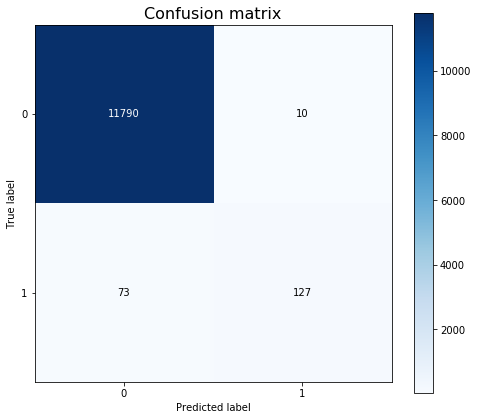

36600

In [62]:
y_pred = model_full_rf.predict(X_val)
y_pred_proba = model_full_rf.predict_proba(X_val)

# the confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_val, y_pred).ravel()

# visualizing the matrix
skplt.metrics.plot_confusion_matrix(Y_val, y_pred, normalize = False, figsize=(8, 7))
plt.title("Confusion matrix", fontsize = 16)
plt.ylim(1.5, -0.5)
plt.show()

#Calculate the cost when we use this model
10*fp + 500*fn 

In [63]:
scores = model_full_rf.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(Y_val, scores)

In [64]:
min_cost = np.inf
best_thresh = 0.2
costs = []

for thresh in thresholds:
    y_pred_thresh = scores > thresh
    tn, fp, fn, tp = confusion_matrix(Y_val, y_pred_thresh).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    
    if cost < min_cost:
        min_cost = cost
        best_thresh = thresh
        
print("These values are on the Validation Set")
print("Best threshold: {:.4f}".format(best_thresh))
print("Min cost: {:.2f}".format(min_cost))

These values are on the Validation Set
Best threshold: 0.0222
Min cost: 6500.00


In [65]:
y_pred_test_final = model_full_rf.predict_proba(test_data)[:,1] > best_thresh
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_final).ravel()

10*fp + 500*fn

9320

In [66]:
recall = tp / (tp + fn)
recall

0.9813333333333333